In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torchvision.transforms as transforms
import torchvision.datasets
import numpy as np
import os
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(torch.cuda.is_available())

False


In [3]:
# Load/Path To Dataset
test = './dogs-vs-cats-redux-kernels-edition/test/test'
train = './dogs-vs-cats-redux-kernels-edition/train/train'
train_files = os.listdir(train)
test_files = os.listdir(test)

# Image Transformations
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),transforms.Resize([32,32]), transforms.ToTensor()])



In [4]:
# Dataloader Test
class DogsCatsData(Dataset):
    def __init__(self, file_list, dir, mode='train', transform= None):
        self.file_list = file_list
        self.dir = dir
        self.mode = mode
        self.transform = transform
        if self.mode == 'train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0

    def __len__ (self):
        return len(self.file_list)

    def __getitem__ (self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]


cat_files = [tf for tf in train_files if 'cat' in tf]
dog_files = [tf for tf in train_files if 'dog' in tf]

cats = DogsCatsData(cat_files, train, transform = transform)
dogs = DogsCatsData(dog_files, train, transform = transform)
catdogs = ConcatDataset([cats, dogs])

In [5]:
dataloader = DataLoader(catdogs, batch_size= 32, shuffle=True, num_workers=0)

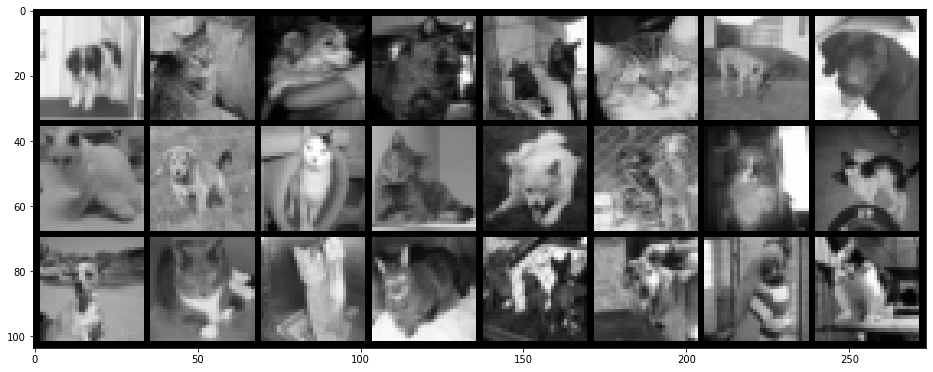

In [6]:
samples, labels = iter(dataloader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [7]:
#pre load model
model = torchvision.models.densenet121(pretrained=True)

In [8]:
# example from pytorch
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


model = Net()

In [19]:
device = 'cpu'
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 500),
    nn.Linear(500, 2)
)

#model.cuda()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, amsgrad=True)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500,1000,1500], gamma=0.5)

In [ ]:
epochs = 3
itr = 1
p_itr = 200
model.train()
total_loss = 0
loss_list = []
acc_list = []
for epoch in range(epochs):
    for samples, labels in dataloader:
        samples, labels = samples.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(samples)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        scheduler.step()
        
        if itr%p_itr == 0:
            pred = torch.argmax(output, dim=1)
            correct = pred.eq(labels)
            acc = torch.mean(correct.float())
            print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(epoch+1, epochs, itr, total_loss/p_itr, acc))
            loss_list.append(total_loss/p_itr)
            acc_list.append(acc)
            total_loss = 0
            
        itr += 1

plt.plot(loss_list, label='loss')
plt.plot(acc_list, label='accuracy')
plt.legend()
plt.title('training loss and accuracy')
plt.show()

In [ ]:
filename_pth = 'ckpt_testnet_catdog.pth'
torch.save(model.state_dict(), filename_pth)

In [22]:
test_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

testset = DogsCatsData(test_files, test, mode='test', transform = test_transform)
testloader = DataLoader(testset, batch_size = 32, shuffle=False, num_workers=0)

In [23]:
import pandas as pd
model.eval()
fn_list = []
pred_list = []
for x, fn in testloader:
    with torch.no_grad():
        x = x.to(device)
        output = model(x)
        pred = torch.argmax(output, dim=1)
        fn_list += [n[:-4] for n in fn]
        pred_list += [p.item() for p in pred]

submission = pd.DataFrame({"id":fn_list, "label":pred_list})
submission.to_csv('notraindensenet.csv', index=False)

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

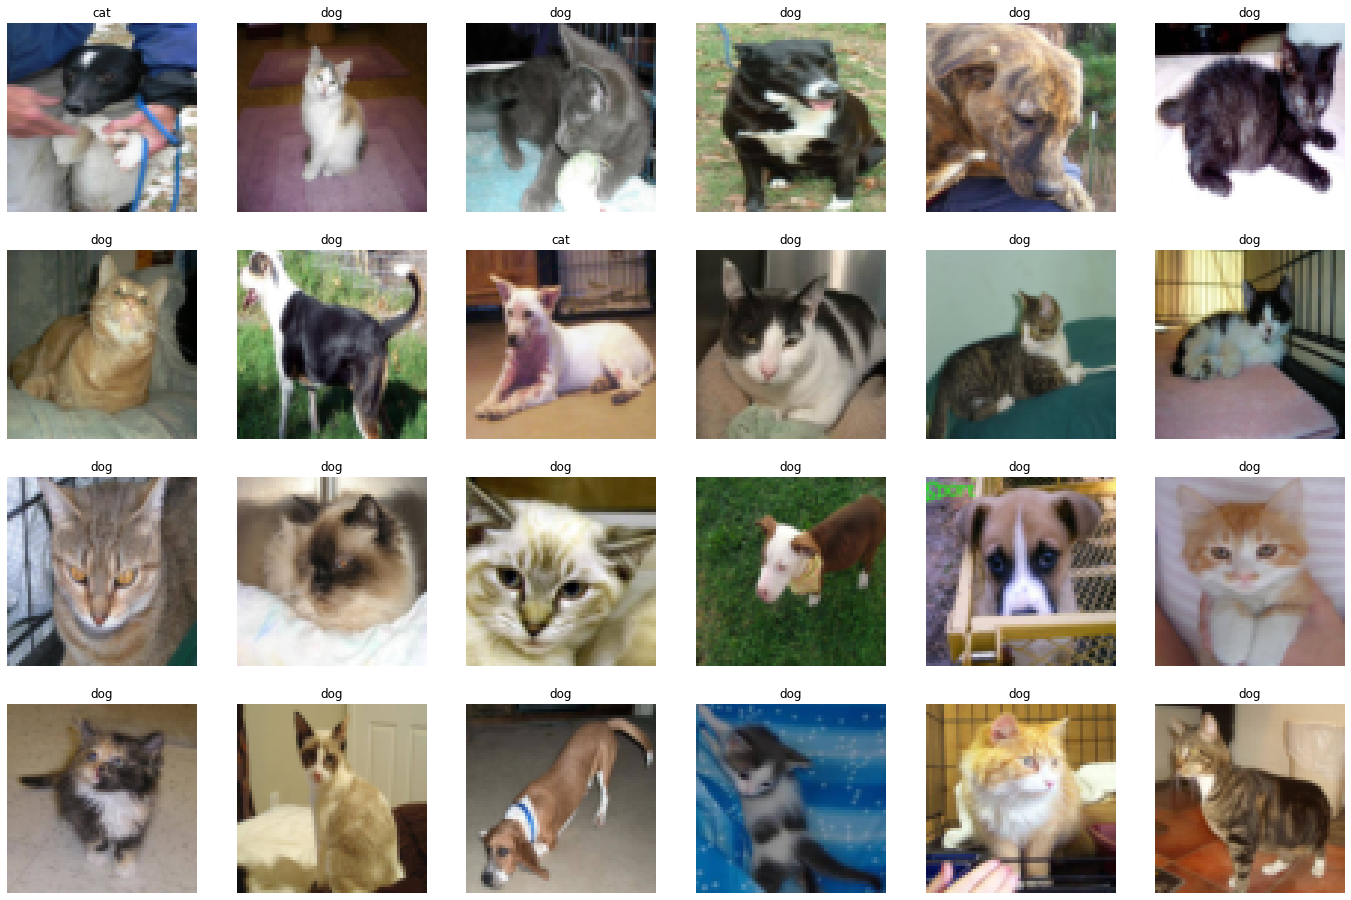

In [24]:
samples, _ = iter(testloader).next()
samples = samples.to(device)
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}
for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))